# Flowers classification probelm using ResNet50

## Download the data

In [1]:
# Check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 12 13:45:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.1 MB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 


In [3]:
# Imports
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, RandomFlip, RandomRotation, RandomWidth, RandomZoom, RandomContrast, MaxPooling2D, GlobalMaxPooling2D, RandomHeight, Dense
import os
import tempfile
from gc import callbacks
from tensorflow.keras.utils import plot_model
import os
import time
from PIL import Image
import PIL.Image
import pandas as pd
from sklearn.metrics import accuracy_score
from google.colab import files
import numpy as np



In [4]:
# Make a directory for data
if not os.path.isdir("/content/dataset/"):
  os.mkdir("dataset")

In [5]:
# Set global variables
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

In [6]:
# Load the dataset, split data
from tensorflow_datasets.core import dataset_info
all_data, info= tfds.load(name="tf_flowers", batch_size=BATCH_SIZE, with_info=True, data_dir="/content/dataset/", split=["train[:70%]", "train[70%:]"], shuffle_files=True, as_supervised=True)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /content/dataset/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
train_data = all_data[0]
test_data = all_data[1]

In [8]:
# Get the length of each data set
len(train_data), len(test_data)


(81, 35)

In [9]:
# Get the class names
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
num_classes, class_names

(5, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'])

## Data Augmentation

In [10]:
# Augmentation of the training data
def data_augment(image, label):
  data_augmentation = tf.keras.Sequential([
                                         RandomFlip("horizontal"),
                                         RandomRotation(0.2),
                                         RandomZoom(0.2),
                                         RandomHeight(0.2),
                                         RandomWidth(0.2),
                                         RandomContrast(0.2)
  ])
  return data_augmentation(image), label

train_data = train_data.map(data_augment)

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
def format_image(image, label):
  image = preprocess_input(tf.image.resize(image, IMG_SIZE))
  return image,label

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [12]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
training_ds = train_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = test_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Base model

In [13]:
# Create the basemodel with EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

base_model = ResNet50(input_shape=(IMG_SIZE + (3,)),
                                         include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


## Feature Extraction

### Create the model

In [14]:
# Initially the base model is not trained
base_model.trainable = False

In [15]:
# Use GlobalMaxPooling
max_pool_layer = GlobalMaxPooling2D()

In [16]:
# Define the prediction layer
prediction_layer = Dense(num_classes, activation="softmax")

In [17]:
from tensorflow.keras import Input, Model

inputs = Input(shape=IMG_SIZE + (3,))
#x = preprocess_input(inputs)
#x = data_augmentation(x)
x = base_model(inputs)
x = max_pool_layer(x)
x = Dropout(0.5)(x)
outputs = prediction_layer(x)
model_1 = Model(inputs, outputs, name="flowers_resnet50")

### Compile the model

In [18]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

In [19]:
# Set the learning rate for feature extraxtion
base_learning_rate = 0.001

# Compile the model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                metrics=["accuracy"])


### Train the model

In [20]:
from gc import callbacks
initial_epochs = 10
model_1_history = model_1.fit(training_ds,
                              validation_data=testing_ds,
                              batch_size=BATCH_SIZE,
                              epochs=initial_epochs,
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 7.5739 - accuracy: 0.4340INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 154s 2s/step - loss: 7.5739 - accuracy: 0.4340 - val_loss: 1.5022 - val_accuracy: 0.7975
Epoch 2/10
80/81 [============================>.] - ETA: 0s - loss: 4.0130 - accuracy: 0.6477INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 35s 436ms/step - loss: 4.0056 - accuracy: 0.6477 - val_loss: 1.4460 - val_accuracy: 0.8111
Epoch 3/10
80/81 [============================>.] - ETA: 0s - loss: 3.1158 - accuracy: 0.7059INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 35s 439ms/step - loss: 3.1053 - accuracy: 0.7065 - val_loss: 1.1765 - val_accuracy: 0.8520
Epoch 4/10
80/81 [============================>.] - ETA: 0s - loss: 2.7636 - accuracy: 0.7293INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 35s 442ms/step - loss: 2.7570 - accuracy: 0.7299 - val_loss: 1.0663 - val_accuracy: 0.8474
Epoch 5/10
81/81 [==============================] - 11s 133ms/step - loss: 2.3428 - accuracy: 0.7501 - val_loss: 1.1592 - val_accuracy: 0.8483
Epoch 6/10
80/81 [============================>.] - ETA: 0s - loss: 2.1008 - accuracy: 0.7785INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 36s 445ms/step - loss: 2.0958 - accuracy: 0.7785 - val_loss: 0.8903 - val_accuracy: 0.8783
Epoch 7/10
80/81 [============================>.] - ETA: 0s - loss: 1.7521 - accuracy: 0.7977INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 36s 447ms/step - loss: 1.7467 - accuracy: 0.7980 - val_loss: 0.7713 - val_accuracy: 0.8847
Epoch 8/10
81/81 [==============================] - 11s 133ms/step - loss: 1.6955 - accuracy: 0.7964 - val_loss: 0.7942 - val_accuracy: 0.8928
Epoch 9/10
81/81 [==============================] - 11s 132ms/step - loss: 1.5275 - accuracy: 0.8089 - val_loss: 0.9405 - val_accuracy: 0.8756
Epoch 10/10
81/81 [==============================] - 11s 132ms/step - loss: 1.5951 - accuracy: 0.8050 - val_loss: 0.7731 - val_accuracy: 0.9037


### Evaluate the model

In [21]:
# Plot validation and training curves
# Create a function
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
  history: TensorFlow History object.

  Returns:
  Plots of the training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

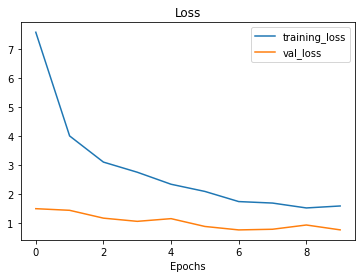

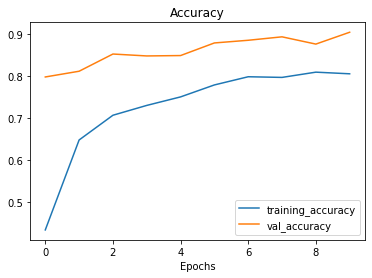

In [22]:
# Plot the curve for loss and accuracy
plot_loss_curves(model_1_history)

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [25]:
# Compile the model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
                metrics=["accuracy"])

In [26]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_1.fit(training_ds,
                         epochs=total_epochs,
                         initial_epoch=model_1_history.epoch[-1] + 1,
                         validation_data=testing_ds,
                         callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 11/25
81/81 [==============================] - ETA: 0s - loss: 1.6779 - accuracy: 0.8178INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 43s 475ms/step - loss: 1.6779 - accuracy: 0.8178 - val_loss: 0.8400 - val_accuracy: 0.8874
Epoch 12/25
81/81 [==============================] - 11s 142ms/step - loss: 0.6723 - accuracy: 0.9035 - val_loss: 0.8521 - val_accuracy: 0.8974
Epoch 13/25
81/81 [==============================] - 11s 142ms/step - loss: 0.4200 - accuracy: 0.9319 - val_loss: 0.9143 - val_accuracy: 0.9055
Epoch 14/25
81/81 [==============================] - 11s 142ms/step - loss: 0.2810 - accuracy: 0.9510 - val_loss: 0.8689 - val_accuracy: 0.9037
Epoch 15/25
80/81 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9699INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 37s 457ms/step - loss: 0.1698 - accuracy: 0.9700 - val_loss: 0.7901 - val_accuracy: 0.9128
Epoch 16/25
81/81 [==============================] - 12s 142ms/step - loss: 0.1713 - accuracy: 0.9685 - val_loss: 0.8544 - val_accuracy: 0.9101
Epoch 17/25
81/81 [==============================] - 11s 142ms/step - loss: 0.1298 - accuracy: 0.9759 - val_loss: 0.9261 - val_accuracy: 0.9074
Epoch 18/25
81/81 [==============================] - 11s 142ms/step - loss: 0.0985 - accuracy: 0.9813 - val_loss: 0.8273 - val_accuracy: 0.9128
Epoch 19/25
81/81 [==============================] - 11s 142ms/step - loss: 0.0572 - accuracy: 0.9872 - val_loss: 0.8246 - val_accuracy: 0.9137
Epoch 20/25
81/81 [==============================] - 12s 143ms/step - loss: 0.0784 - accuracy: 0.9864 - val_loss: 0.8683 - val_accuracy: 0.9055
Epoch 21/25
80/81 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9863INFO:tensorflow:Assets written to: model_experiments/f

INFO:tensorflow:Assets written to: model_experiments/flowers_resnet50/assets


81/81 [==============================] - 37s 465ms/step - loss: 0.0709 - accuracy: 0.9864 - val_loss: 0.7813 - val_accuracy: 0.9255
Epoch 22/25
81/81 [==============================] - 12s 142ms/step - loss: 0.0472 - accuracy: 0.9903 - val_loss: 0.8816 - val_accuracy: 0.9137
Epoch 23/25
81/81 [==============================] - 11s 142ms/step - loss: 0.0313 - accuracy: 0.9922 - val_loss: 0.9902 - val_accuracy: 0.9046
Epoch 24/25
81/81 [==============================] - 11s 142ms/step - loss: 0.0500 - accuracy: 0.9879 - val_loss: 0.9511 - val_accuracy: 0.9101
Epoch 25/25
81/81 [==============================] - 12s 143ms/step - loss: 0.0273 - accuracy: 0.9914 - val_loss: 1.0560 - val_accuracy: 0.9083


In [27]:
# Load in the best saved model
model_1 = tf.keras.models.load_model("/content/model_experiments/flowers_resnet50")

In [28]:
# Evaluate on the best model
model_1.evaluate(testing_ds)

35/35 [==============================] - 4s 94ms/step - loss: 0.7813 - accuracy: 0.9255


[0.7813429832458496, 0.9255222678184509]

## Save the model

In [29]:
model_1.save("flowers_resent50.h5")

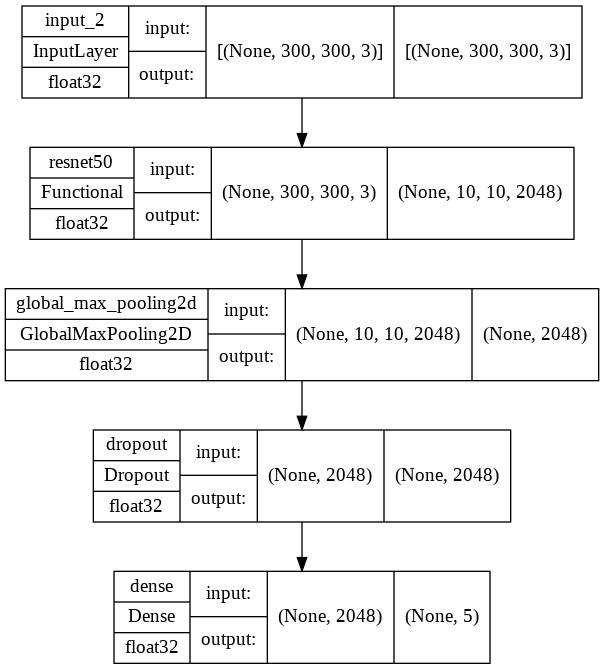

In [30]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model_1, to_file="flowers_resnet50_model.jpeg",show_shapes=True, show_dtype=True)

## Predictions

In [31]:
# Function to load, prep and predict
def load_prep_predict_image(model, image_path, image_size=IMG_SIZE, class_names=class_names):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img)
  plt.imshow(img) 
  plt.axis(False)
  img = preprocess_input(img)
  img = tf.image.resize(img, IMG_SIZE)
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[int(tf.round(pred[[0]]))]
  return pred_class

In [32]:
#load_prep_predict_image(model=model_1, image_path="/content/Horses-400x225.jpg")

In [33]:
model_1.summary()

Model: "flowers_resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 5,530,629
Non-trainable params: 18,067,328
______________________________

In [34]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/flower_photos.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [35]:
val_data = tf.keras.utils.image_dataset_from_directory(directory="/content/flower_photos",
                                              #color_mode="grayscale",
                                              image_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="int")

Found 100 files belonging to 5 classes.


In [36]:
val_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
print(f"The Accuracy of the validation data {model_1.evaluate(val_data)[1] * 100:.2f}%")

4/4 [==============================] - 2s 146ms/step - loss: 28.7934 - accuracy: 0.1500
The Accuracy of the validation data 15.00%


In [38]:
# Function to infer the val images 
import numpy as np
import os
import time
from PIL import Image
import PIL.Image

def benchmark(val_dir, model, class_names=class_names, image_size=IMG_SIZE):
  file_count = 0
  infer_times = []
  for (root, dirs, files) in os.walk(val_dir):
    for name in files:
      if name.endswith(".jpg"):
        filename = os.path.join(root, name)
        if file_count < 1 :
          init_timer_start = time.time()
          img = np.array(Image.open(filename).resize(IMG_SIZE))/255.
          pred = model.predict(np.expand_dims(img, axis=0))
          pred_class = class_names[int(np.argmax(pred[0]))]
          init_timer_end = time.time()
          init_timer = init_timer_end - init_timer_start
          file_count+=1
        else:
          timer_start = time.time()
          img = np.array(Image.open(filename).resize(IMG_SIZE))/255.
          pred = model.predict(np.expand_dims(img, axis=0))
          pred_class = class_names[int(np.argmax(pred[0]))]
          timer_end = time.time()
          infer_times.append((timer_end - timer_start))
          file_count+=1

  return init_timer, np.mean(infer_times), np.std(infer_times)

In [39]:
init_time, avg_time, std = benchmark(val_dir="/content/flower_photos",
          model=model_1)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 1347.64 ms
The average time taken per 99 images 65.84 ms
The standard deviation of samples is 3.62 ms


In [ ]:
init_time, avg_time, std = benchmark(val_dir="/content/flower_photos",
          model=model_1)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 66.20 ms
The average time taken per 99 images 66.84 ms
The standard deviation of samples is 3.03 ms


## Pruning

### Results form the baseline model

In [40]:
baseline_loss, baseline_accuracy = model_1.evaluate(testing_ds)
print(f"The accuracy of the baseline model is {baseline_accuracy * 100:.2f} %")

35/35 [==============================] - 3s 94ms/step - loss: 0.7813 - accuracy: 0.9255
The accuracy of the baseline model is 92.55 %


### Prunig the layers

In [41]:
non_sparse_metric_dict = {
      "sparsity" : 0,
      "val_loss" : np.round(baseline_loss, 4),
      "val_accuracy" : np.round(baseline_accuracy * 100, 4)
}
non_sparse_metric_dict

{'sparsity': 0, 'val_accuracy': 92.5522, 'val_loss': 0.7813}

In [42]:
!pip install tensorflow_model_optimization 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 237 kB 4.0 MB/s 


In [43]:
import tensorflow_model_optimization as tfmot

# Finish pruning after 2 epochs
epochs = 2
BATCH_SIZE = 32
#print(len(validation_batches))

In [44]:
from tensorflow_model_optimization.python.core.keras import metrics
def prune_model(model, initial_sparsity, final_sparsity, train_data=training_ds, val_data=testing_ds, epochs=epochs ):
  # Create a tensorboard logfile
  logdir = tempfile.mkdtemp()
  # The end_step is the total number of iterations required for the training data which is basically the entire epochs over the length of the training data
  end_step = int(len(train_data) * epochs *0.5)
  # Import the low-magnitude-pruning function
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
  # Set the prunung params
  pruning_params = {
      "pruning_schedule" : tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                                final_sparsity=final_sparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
                  }

  
  learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    0.001,
    1000,
    0.0001,
    power=0.5)
  
  # Model for pruning
  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # Recompile
  model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                            metrics=["accuracy"])
  #create callbacks
  callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
              tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                   patience=3,
                                                   verbose=1)]
  
  # Fit the model
  model_for_pruning.fit(train_data,
                      validation_data=val_data,
                      batch_size=BATCH_SIZE,
                      epochs=epochs,
                      callbacks=callbacks)
  
  # Save the model
  #model_for_pruning.save(f"mnist_model_sparsity_{final_sparsity}")

  # Evaluate the model
  score = model_for_pruning.evaluate(val_data, verbose=0)
  metric_dict = {
      "sparsity" : final_sparsity,
      "val_loss" : np.round(score[0], 4),
      "val_accuracy" : np.round(score[1] * 100, 4)
  }
  return logdir, metric_dict, model_for_pruning

In [ ]:
k_sparsities = [0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]

#k_sparsities = [0.50]
metric_list = []
for k in k_sparsities:
  logdir, metrics, pruned_model = prune_model(model=model_1,
            initial_sparsity=0,
            final_sparsity=k,
            epochs=10)
  val_loss, val_accuracy  = metrics["val_loss"], metrics["val_accuracy"]
  metric_list.append(metrics)
  print(f"Sparsity : {k} \tValidation Loss: {val_loss}, \tValidation Accuracy: {val_accuracy}")

# Create a dataframe of the values obtained
df = pd.DataFrame(metric_list)

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)


Epoch 1/10
81/81 [==============================] - 34s 327ms/step - loss: 0.7183 - accuracy: 0.8260 - val_loss: 0.8898 - val_accuracy: 0.8274 - lr: 0.0010
Epoch 2/10
81/81 [==============================] - 24s 302ms/step - loss: 0.4733 - accuracy: 0.8673 - val_loss: 0.8504 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 3/10
81/81 [==============================] - 24s 297ms/step - loss: 0.3592 - accuracy: 0.8922 - val_loss: 0.4012 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 4/10
81/81 [==============================] - 24s 297ms/step - loss: 0.3110 - accuracy: 0.9066 - val_loss: 0.4860 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 5/10
81/81 [==============================] - 24s 297ms/step - loss: 0.2364 - accuracy: 0.9202 - val_loss: 0.4679 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 6/10
81/81 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9303
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
81/81 [==============================] - 24s 297m

In [ ]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
#docs_infra: no_execute
%tensorboard --logdir={logdir}

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
df

,sparsity,val_loss,val_accuracy
0,0.25,0.3450,92.1889
1,0.50,0.4376,92.3706
2,0.60,0.3882,92.0981
3,0.70,0.4060,92.0981
4,0.80,0.5173,90.8265
5,0.90,0.4457,89.9183
6,0.95,0.3939,89.7366
7,0.97,0.4407,89.1916
8,0.99,0.3627,89.0100


In [ ]:
baseline_accuracy

0.912806510925293

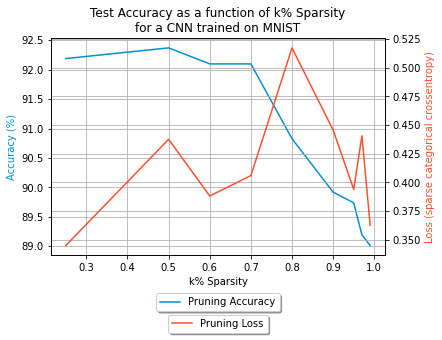

In [ ]:
from IPython.core.pylabtools import figsize
# Visualizing performance on MNIST
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.grid(b=None)
ax2 = ax1.twinx()
plt.grid(b=None)
plt.title('Test Accuracy as a function of k% Sparsity\nfor a CNN trained on MNIST')
ax1.plot(df['sparsity'].values,
         df['val_accuracy'].values,
         '#008fd5', linestyle='-', label='Pruning Accuracy')
ax2.plot(df['sparsity'].values,
         df['val_loss'].values,
         '#fc4f30', linestyle='-', label='Pruning Loss')

ax1.set_ylabel('Accuracy (%)', color='#008fd5')
ax2.set_ylabel('Loss (sparse categorical crossentropy)', color='#fc4f30')
ax1.set_xlabel('k% Sparsity')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2);
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2);
plt.savefig('MNIST_sparsity_comparisons.png')

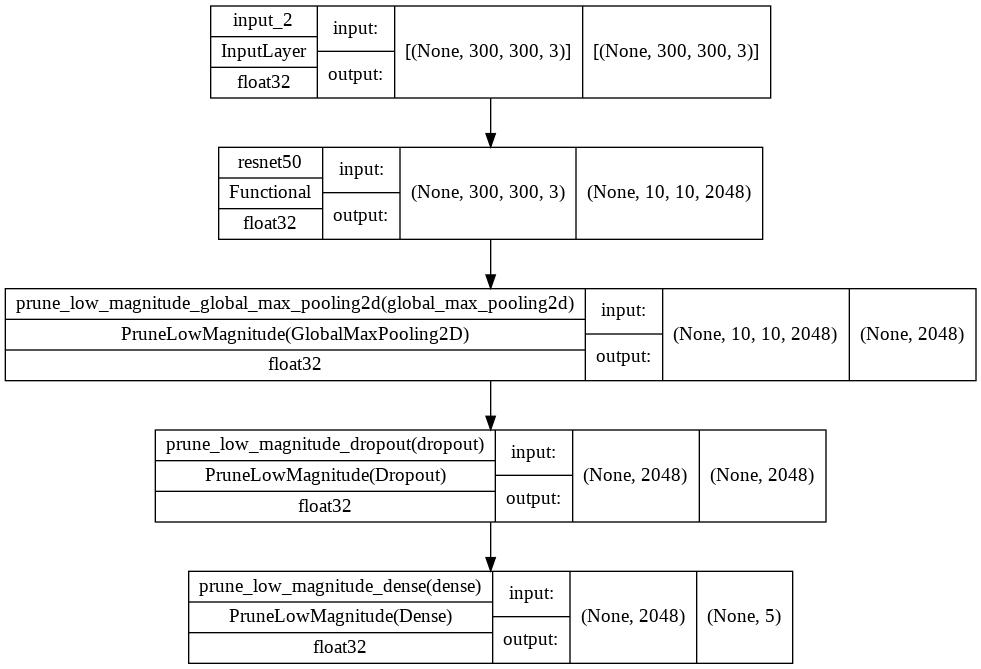

In [ ]:
plot_model(pruned_model, to_file="pruned_model.jpeg",show_shapes=True, show_dtype=True)

In [ ]:
pruned_model.summary()

Model: "flowers_resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      47042851  
                                                                 
 prune_low_magnitude_global_  (None, 2048)             1         
 max_pooling2d (PruneLowMagn                                     
 itude)                                                          
                                                                 
 prune_low_magnitude_dropout  (None, 2048)             1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense (  (None, 5)                20487     
 PruneLowMagnitude)                               

In [ ]:
model_1.summary()

Model: "flowers_resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 4,475,909
Non-trainable params: 19,122,048
______________________________

In [54]:
benchmark_dir = "/content/flower_photos"

In [ ]:
init_time, avg_time, std = benchmark(val_dir=benchmark_dir,
          model=model_1)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 82.13 ms
The average time taken per 99 images 73.79 ms
The standard deviation of samples is 6.16 ms


In [45]:
logdir, metrics, pruned_model = prune_model(model=model_1,
            initial_sparsity=0,
            final_sparsity=0.7,
            epochs=15)

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)


Epoch 1/15
 6/81 [=>............................] - ETA: 11s - loss: 0.3783 - accuracy: 0.9844WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1388s vs `on_train_batch_end` time: 0.2017s). Check your callbacks.


81/81 [==============================] - 64s 216ms/step - loss: 1.3709 - accuracy: 0.8494 - val_loss: 1.2932 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 2/15
81/81 [==============================] - 16s 202ms/step - loss: 0.6569 - accuracy: 0.8976 - val_loss: 0.6782 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 3/15
81/81 [==============================] - 15s 191ms/step - loss: 0.4574 - accuracy: 0.9229 - val_loss: 0.8863 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 4/15
81/81 [==============================] - 15s 191ms/step - loss: 0.5586 - accuracy: 0.9105 - val_loss: 0.8535 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 5/15
81/81 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.8828
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
81/81 [==============================] - 15s 191ms/step - loss: 0.7158 - accuracy: 0.8828 - val_loss: 1.0462 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 6/15
81/81 [==============================] - 15s 186ms/step - lo

logdir, metrics, pruned_model = prune_model(model=model_1,
            initial_sparsity=0,
            final_sparsity=0.6,
            epochs=50)

### Pruned model evaluation

In [46]:
pruned_model.evaluate(testing_ds)

35/35 [==============================] - 3s 98ms/step - loss: 0.6732 - accuracy: 0.9028


[0.673194408416748, 0.9028156399726868]

### Save the pruned model

### Save the pruned model

In [47]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmp5f3vpi32.h5


In [48]:
pruned_model.evaluate(testing_ds)

35/35 [==============================] - 3s 97ms/step - loss: 0.6732 - accuracy: 0.9028


[0.673194408416748, 0.9028156399726868]

In [ ]:
#load = tf.keras.models.load_model("/tmp/tmpde477j_2.h5")

### Save the tflite model

In [ ]:
#loaded = tf.keras.models.load_model("/content/flower_pruned_model_70.h5")

In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
orginal_tflite_model = converter.convert()

_, orginal_tflite_file = tempfile.mkstemp('.tflite')

with open(orginal_tflite_file, 'wb') as f:
  f.write(orginal_tflite_model)

print('Saved pruned TFLite model to:', orginal_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmp22dblc8a/assets


INFO:tensorflow:Assets written to: /tmp/tmp22dblc8a/assets


Saved pruned TFLite model to: /tmp/tmpyjatjzos.tflite


In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpeq9o6drj/assets


INFO:tensorflow:Assets written to: /tmp/tmpeq9o6drj/assets


Saved pruned TFLite model to: /tmp/tmprc9dhz7o.tflite


### Convert pruned model to `Quantized tflite model`

In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpo0zym97b/assets


INFO:tensorflow:Assets written to: /tmp/tmpo0zym97b/assets


Saved quantized and pruned TFLite model to: /tmp/tmpwyy5s70j.tflite


In [52]:
def benchmark_tflite(val_dir, tflite_model, class_names=class_names, image_size=IMG_SIZE):
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  file_count = 0
  infer_times = []
  for (root, dirs, files) in os.walk(val_dir):
    for name in files:
      if name.endswith(".jpg"):
        filename = os.path.join(root, name)
        if file_count < 1 :
          init_timer_start = time.time()
          img = (np.array(Image.open(filename).resize(image_size))).astype(np.float32)
          img = np.expand_dims(img, axis=0)
          #img = np.expand_dims(img, axis=3)
          #init_timer_start = time.time()
          interpreter.set_tensor(input_index, img)
          interpreter.invoke()
          output = interpreter.tensor(output_index)
          pred_class = class_names[int(np.argmax(output()[0]))]
          init_timer_end = time.time()
          init_timer = init_timer_end - init_timer_start
          file_count+=1
        else:
          timer_start = time.time()
          img = (np.array(Image.open(filename).resize(image_size))).astype(np.float32)
          img = np.expand_dims(img, axis=0)
          interpreter.set_tensor(input_index, img)
          interpreter.invoke()
          output = interpreter.tensor(output_index)
          pred_class = class_names[int(np.argmax(output()[0]))]
          timer_end = time.time()
          infer_times.append((timer_end - timer_start))
          file_count+=1

  return init_timer, np.mean(infer_times), np.std(infer_times)

### Benchmark of the orginal model

In [ ]:
init_time, avg_time, std = benchmark(val_dir=benchmark_dir,
          model=model_1)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 1536.45 ms
The average time taken per 99 images 60.31 ms
The standard deviation of samples is 5.01 ms


In [ ]:
init_time, avg_time, std = benchmark(val_dir=benchmark_dir,
          model=model_for_export)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 68.38 ms
The average time taken per 99 images 70.06 ms
The standard deviation of samples is 59.72 ms


### Benchmark of the pruned tflite model

In [56]:
init_time, avg_time, std = benchmark_tflite(val_dir=benchmark_dir,
          tflite_model=orginal_tflite_model)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

The first image takes 464.96 ms
The average time taken per 99 images 459.80 ms
The standard deviation of samples is 39.13 ms


### Bnechmark quantized pruned model

In [ ]:
init_time, avg_time, std = benchmark_tflite(val_dir=benchmark_dir,
          tflite_model=quanti)
print(f"The first image takes {init_time * 1000:.2f} ms")
print(f"The average time taken per 99 images {avg_time * 1000:.2f} ms")
print(f"The standard deviation of samples is {std * 1000:.2f} ms")

### Get details of the pruned tflite model

In [ ]:
pruned_tflite_interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)
pruned_tflite_interpreter.allocate_tensors()

In [ ]:
input_details = pruned_tflite_interpreter.get_input_details()
output_details = pruned_tflite_interpreter.get_output_details()

print("INPUT/OUTPUT DETAILS BEFORE RESIZING")
print("Input: ", input_details[0]["shape"])
print("Output: ", output_details[0]["shape"])

INPUT/OUTPUT DETAILS BEFORE RESIZING
Input:  [  1 300 300   3]
Output:  [1 5]


In [ ]:
# Resize the inputs and ouputs for batches
pruned_tflite_interpreter.resize_tensor_input(input_details[0]["index"], (BATCH_SIZE, 300, 300, 3))
pruned_tflite_interpreter.resize_tensor_input(output_details[0]["index"], (BATCH_SIZE, 5))
pruned_tflite_interpreter.allocate_tensors()

input_details = pruned_tflite_interpreter.get_input_details()
output_details = pruned_tflite_interpreter.get_output_details()

print("INPUT/OUTPUT DETAILS AFTER RESIZING")
print("Input: ", input_details[0]["shape"])
print("Output: ", output_details[0]["shape"])

INPUT/OUTPUT DETAILS AFTER RESIZING
Input:  [ 32 300 300   3]
Output:  [32  5]


In [ ]:
def normalize_image(image, label):
  image = tf.cast(tf.image.resize(image, IMG_SIZE), tf.float32)
  return image,label

In [ ]:
testing_ds = testing_ds.map(normalize_image)
test_image_batch, test_label_batch = next(iter(testing_ds))
print(test_image_batch.shape)

#test_image_batch = np.array(test_image_batch).astype(np.float32)
print(test_image_batch.shape)
print(test_label_batch)


(32, 300, 300, 3)
(32, 300, 300, 3)
tf.Tensor([4 0 1 3 0 3 0 3 1 3 0 1 1 2 4 3 4 2 2 0 0 1 2 2 3 3 3 3 3 1 0 4], shape=(32,), dtype=int64)


### Evaluation function for tflite model


In [57]:
import tqdm
def evaluate_tflite_model(tflite_model, test_data=testing_ds, BATCH_SIZE=BATCH_SIZE):
  toolbar_width = 40
  # Assigne the interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  # Get input output detals
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  # Resize the inputs and ouputs for batches
  # (BATCH_SIZE=32, IMAGE_SHAPE=28, IMAGE_SHAPE=28, CHANNELS=1)
  interpreter.resize_tensor_input(input_details[0]["index"], (BATCH_SIZE, input_details[0]["shape"][1], input_details[0]["shape"][2], input_details[0]["shape"][3]))
  # (BATCH_SIZE=32, NUM_CLASSES=10)
  interpreter.resize_tensor_input(output_details[0]["index"], (BATCH_SIZE, output_details[0]["shape"][1]))
  interpreter.allocate_tensors()
  print("this")
  y_preds = []
  y_true = []
  for batch in tqdm.tqdm(range(len(test_data))):
    time.sleep(0.01)
    image_batch, label_batch = next(iter(test_data))
    # Run inference
    interpreter.set_tensor(input_details[0]["index"], image_batch)
    interpreter.invoke()
    pruned_tflite_pred_probs = interpreter.get_tensor(output_details[0]["index"])
    pruned_tflite_preds = np.argmax(pruned_tflite_pred_probs, axis=1).tolist()
    y_preds += pruned_tflite_preds
    label_batch = np.array(label_batch).tolist()
    y_true +=label_batch

  return accuracy_score(y_true, y_preds)


### Evaluate the pruned tflite model

In [ ]:
evaluate_tflite_model(orginal_tflite_model, test_data=testing_ds)

this


100%|██████████| 35/35 [06:43<00:00, 11.54s/it]


0.125

In [58]:
evaluate_tflite_model(pruned_tflite_model, test_data=testing_ds)

this


100%|██████████| 35/35 [08:06<00:00, 13.91s/it]


0.90625

### Evaluate the quantized tflite model

In [ ]:
quantized_model_accuracy = evaluate_tflite_model(quantized_and_pruned_tflite_model, test_data=testing_ds)
quantized_model_accuracy

this


  0%|          | 0/35 [10:06<?, ?it/s]


KeyboardInterrupt: ignored

### Download the quantized model

In [59]:
# Function to rename and download a model
def download_model(model_file, new_name):
  os.rename(model_file, new_name)
  files.download(new_name)

In [65]:
quantized_file_name = "flower_quantized_pruned_model.tflite"
download_model(quantized_and_pruned_tflite_file, quantized_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download the pruned tflite model

In [61]:
pruned_tflite_file_name = "flower_pruned_tflite_model.tflite"
download_model(pruned_tflite_file, pruned_tflite_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
orginal_tflite_file_name = "flower_orginal_tflite_model.tflite"
download_model(orginal_tflite_file, orginal_tflite_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download th pruned model

In [62]:
pruned_file_name = "flower_pruned_model_70.h5"
download_model(pruned_keras_file, pruned_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
load = tf.keras.models.load_model("/content/flower_pruned_model_70.h5")

ValueError: ignored

In [ ]:
pruned_model.save("flower_pruned_model_70.h5")